# Week 5 - Logistic Regression and Classification Error Metrics

## Franklin Abreu PID: 6134148

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

Alternatively the same data set can be found at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones/downloads/human-activity-recognition-with-smartphones.zip
The train file can be renamed as Human_Activity_Recognition_Using_Smartphones_Data.csv 

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website above.

In [1]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
data_path = ['..', 'data']

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [2]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [3]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [4]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [5]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [6]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [7]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data["Activity"] = le.fit_transform(data["Activity"]).astype(np.int_)
data["Activity"].sample(5)

104     3
6731    3
6196    4
637     4
8650    3
Name: Activity, dtype: int32

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [9]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
    .stack()
    .to_frame()
    .reset_index()
    .rename(columns={
        "level_0": "feature1",
        "level_1": "feature2",
        0: "correlation"
    })
)

# Get the absolute values for sorting
corr_values["abs_correlation"]= corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

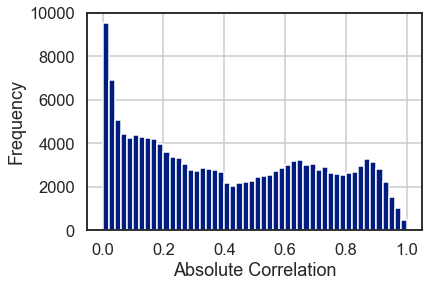

In [11]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel="Absolute Correlation", ylabel="Frequency");

In [12]:
# The most highly correlated values
corr_values.sort_values("correlation", ascending=False).query("abs_correlation>0.8")

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3,random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data["Activity"]))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, "Activity"]

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, "Activity"]


In [14]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [16]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
# max_iter=23000

lr = LogisticRegression().fit(X_train, y_train)


D:\Users\FranklinAbreu\anaconda3\envs\cnt4155\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty="l1", solver="liblinear").fit(X_train, y_train)

In [ ]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

In [18]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty="l2").fit(X_train, y_train)

D:\Users\FranklinAbreu\anaconda3\envs\cnt4155\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Users\FranklinAbreu\anaconda3\envs\cnt4155\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [19]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab, mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_

    coeff_label = pd.MultiIndex.from_product([[lab], [0,1,2,3,4,5]], 
                                             names=["coeff_labels", "coefficient"])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)
coefficients.sample(10)

coeff_labels        lr                                                    \
coefficient          0         1         2         3         4         5   
490          -0.022062  0.027934  0.074747 -0.416924 -0.038110  0.374413   
342           0.011047  0.019849  0.049215  0.021032 -0.103698  0.002554   
424          -0.075475 -0.086042 -0.040437  0.159500  0.096987 -0.054533   
519          -0.079117 -0.076200  0.037037 -0.209731  0.060915  0.267097   
210          -0.057589  0.025536  0.024699 -0.070745  0.207881 -0.129782   
555           0.090845 -0.128001  0.091030  0.086146 -0.153502  0.013482   
57            1.383632 -0.287625 -0.698341 -0.359355 -0.586887  0.548576   
85           -0.078379  0.034176 -0.093573  0.144541  0.217708 -0.224473   
245          -0.037105  0.022902 -0.047042 -0.145434  0.138881  0.067797   
453           0.167218  0.039813 -0.193247  0.098091 -0.087399 -0.024475   

coeff_labels        l1                                                    \
coefficient          0         1         2         3         4         5   
490           0.000000  0.104374  0.047607 -0.134112  0.006845  0.807939   
342           0.000000  0.000000  0.000000  0.000000 -0.003968 -0.231832   
424           0.000000  0.000000  0.000000  0.000000  0.000000 -0.253765   
519           0.000000  0.000000  0.000000  0.000000  0.130957  0.441685   
210           0.000000  0.000000  0.000000  0.000000  0.370589  0.902095   
555           0.000000 -0.362451  0.324681  0.152306 -0.511869 -0.316980   
57            0.061475  0.181843 -4.049493  0.000000 -0.515030  1.132785   
85            0.000000  0.000000  0.000000  0.000000  0.406468 -0.408035   
245           0.000000  0.000000  0.000000  0.000000  0.091690 -0.224635   
453           0.000000  0.000000 -0.401042  0.000000 -0.157793 -0.072844   

coeff_labels        l2                                                    
coefficient          0         1         2         3         4         5  
490          -0.072196 -0.004932  0.104496 -0.517655 -0.096531  0.586818  
342           0.011742  0.030408  0.053825  0.015387 -0.082435 -0.028925  
424          -0.038595 -0.245220  0.143374  0.130379  0.040589 -0.030526  
519          -0.104725 -0.179450  0.140918 -0.235714  0.064536  0.314435  
210          -0.083130  0.108696 -0.061065 -0.049682  0.209720 -0.124539  
555           0.100738 -0.183389  0.176463  0.044706 -0.139874  0.001356  
57            1.939555  0.914945 -2.747900 -0.414739 -0.616355  0.924493  
85           -0.077134  0.116934 -0.193321  0.158570  0.274299 -0.279348  
245          -0.050877  0.094439 -0.143499 -0.155248  0.214654  0.040530  
453           0.282838  0.010476 -0.312548 -0.008984 -0.010203  0.038420

Prepare six separate plots for each of the multi-class coefficients.

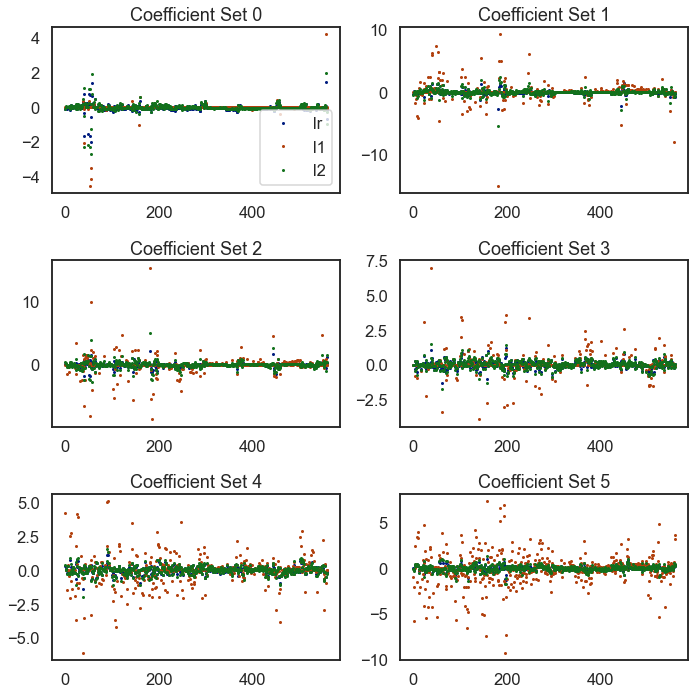

In [20]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    dat = coefficients.xs(loc, level=1, axis=1)
    dat.plot(marker="o", ls="", ms=2.0, ax=ax, legend=False)

    if ax is axList[0]:
        ax.legend(loc=4)
    ax.set(title=f"Coefficient Set {loc}")

plt.tight_layout()
    

## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [21]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab, mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))

y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [22]:
y_prob.head()

,lr,l1,l2
0,0.999995,0.998952,0.999997
1,0.999237,0.999342,0.999692
2,0.997399,0.995317,0.998990
3,0.988779,0.999155,0.997796
4,0.995023,0.999922,0.999371


## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [23]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()
clsses = [0,1,2,3,4,5]

for lab in coeff_labels:
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average="weighted")

    acc = accuracy_score(y_test, y_pred[lab])

    auc = roc_auc_score(label_binarize(y_test, classes=clsses),
                        label_binarize(y_pred[lab], classes=clsses),
                        average="weighted")
    cm[lab] = confusion_matrix(y_test, y_pred[lab])

    metrics.append(pd.Series({
        "precision": precision,
        "recall":recall,
        "fscore": fscore,
        "accuracy": acc,
        "auc": auc
    }, name=lab))

metrics = pd.concat(metrics, axis=1)

In [ ]:
#Run the metrics
metrics

## Question 8

Display or plot the confusion matrix for each model.

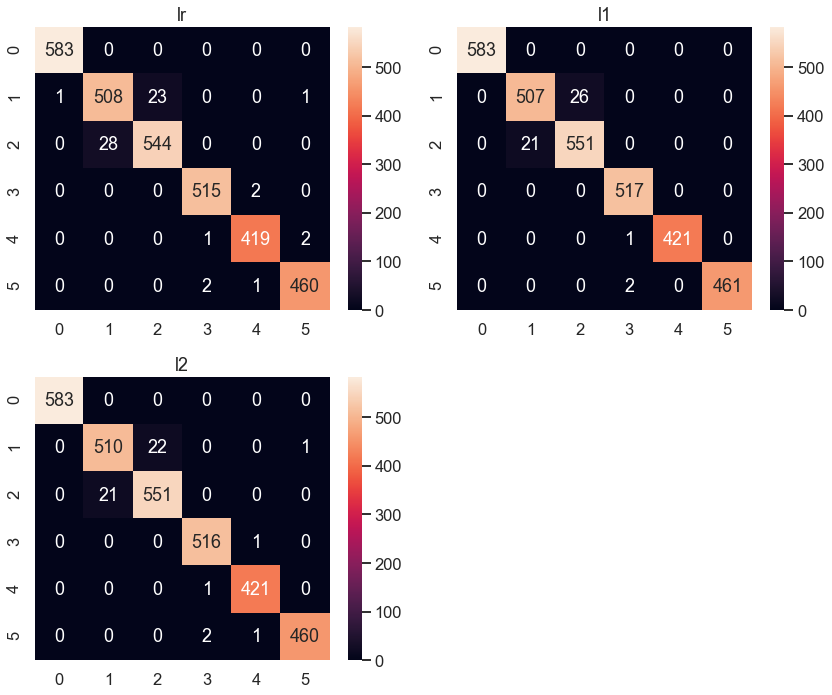

In [24]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis("off")

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt="d")
    ax.set(title=lab);

plt.tight_layout()

## Question 9
 Identify highly correlated columns and drop those columns before building models

In [25]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#threshold with .7
threshold = 0.7
vt = VarianceThreshold(threshold=(threshold * (1 - threshold)))

dat2 = pd.concat([X_train, X_test])
new_data = pd.DataFrame(vt.fit_transform(dat2))


y_data = pd.concat([y_train, y_test])

X_train_new, X_test_new = train_test_split(new_data, test_size=0.3, random_state=42)
y_train_new, y_test_new = train_test_split(y_data, test_size=0.3, random_state=42)

y_train_new.value_counts(normalize=True)

2    0.187127
0    0.186711
1    0.171175
3    0.163129
5    0.155361
4    0.136496
Name: Activity, dtype: float64

 Repeat Model building with new training data after removing higly correlated columns

In [26]:
# Try standard, L1 and L2 Logistic regression
lr = LogisticRegression().fit(X_train_new, y_train_new)

lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty="l1", solver="liblinear").fit(X_train_new, y_train_new)

lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty="l2").fit(X_train_new, y_train_new)

D:\Users\FranklinAbreu\anaconda3\envs\cnt4155\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Users\FranklinAbreu\anaconda3\envs\cnt4155\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\Users\FranklinAbreu\anaconda3\envs\cnt4155\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "

In [ ]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [27]:
# Combine all the coefficients into a dataframe for comparison
coefficients2 = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex.from_product([[lab], [0,1,2,3,4,5]], 
                                             names=["coeff_labels", "coefficient"])
    coefficients2.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients2 = pd.concat(coefficients2, axis=1)

coefficients2.sample(10)

coeff_labels        lr                                                    \
coefficient          0         1         2         3         4         5   
35           -0.082220  1.129433 -1.722887 -0.369999  1.232685 -0.187012   
2            -1.316411 -1.804844  0.404544 -1.710649  3.675280  0.752079   
39           -0.321986  0.211104 -1.030124  3.176462  1.529469 -3.564925   
28            0.077879 -0.937870  0.384859  0.935418 -0.277543 -0.182742   
8            -3.412975 -2.447456  3.983507  2.640667  0.940404 -1.704149   
26           -0.004283  0.300209 -1.595479  2.512932  0.977151 -2.190529   
15           -0.310401 -4.222649  3.374574  2.192984 -0.004417 -1.030091   
24           -0.096772 -0.242294  0.032339 -1.267257  0.884119  0.689865   
4            -0.681776 -0.617781  0.048010  1.635314 -2.113782  1.730016   
16           -0.159342  0.797376 -0.976680 -0.204552  1.131428 -0.588231   

coeff_labels        l1                                                         \
coefficient          0          1          2          3          4          5   
35            0.000000   3.840887  -3.314638  -3.031356   0.000000   0.472852   
2            -0.161926 -12.456345  -0.965823  -6.224212   8.234620   2.001861   
39            0.000000   0.095483   0.000000  11.561256   8.306621 -11.713099   
28            0.000000  -2.823943   2.294702   8.814079   0.706294  -0.683257   
8            -3.682654 -73.381433  30.740886   8.655823  -7.894426  -5.806342   
26            0.000000   1.528014  -0.207506  21.817463  10.286873 -12.582814   
15            0.000000 -10.781815  10.128022   6.278150   0.000607  -3.715874   
24            0.000000   0.000000   0.000000   5.693598  -0.667522  -0.914154   
4             0.000000  -0.642202   1.875156   3.322505  -6.260649   3.516637   
16            0.000000   1.873657  -1.531239  -0.265717   4.509834  -0.601647   

coeff_labels         l2                                                        
coefficient           0          1          2          3         4          5  
35             0.326318   0.447364  -2.805206  -1.451383  1.721242   1.761665  
2             -4.676689 -15.100120   4.909402   0.492236  9.268141   5.107030  
39            -0.726442  -1.364210  -1.350859   6.720831  4.493385  -7.772706  
28            -0.556118  -2.213400   1.254203   2.932865 -1.373181  -0.044370  
8            -10.894068 -14.900537  20.022742   6.970827 -4.476244   3.277280  
26            -0.072497  -1.950052  -2.943135  15.997396  3.422273 -14.453984  
15            -2.435351  -7.957738   3.352626   7.087149 -0.075925   0.029239  
24             0.831949   0.192984   0.348835   0.033711 -0.282651  -1.124827  
4             -3.375896  -2.436461  -1.243544   5.255686 -3.011953   4.812168  
16            -1.169889   1.277070  -0.749941  -0.149699  1.415920  -0.623460

Prepare six separate plots for each of the multi-class coefficients.

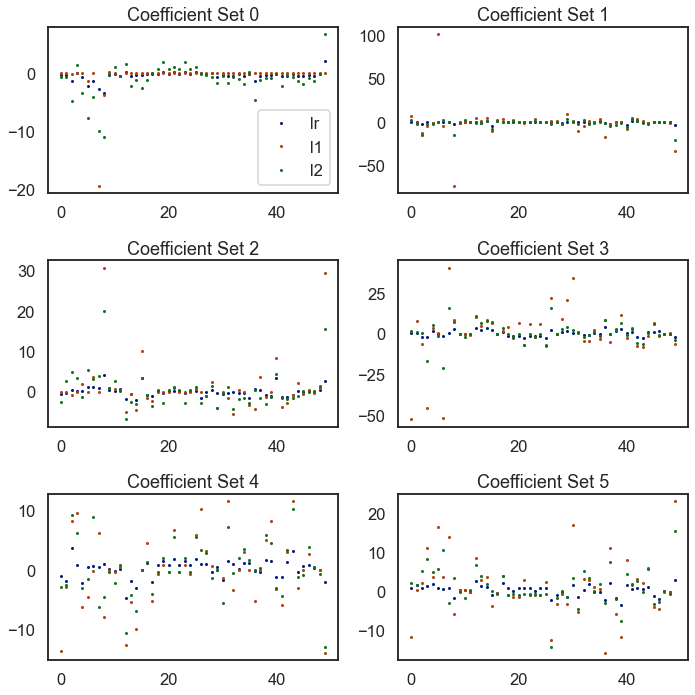

In [28]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    dat = coefficients2.xs(loc, level=1, axis=1)
    dat.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title=f"Coefficient Set {loc}")

plt.tight_layout()
# try the plots

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [29]:
# Predict the class and the probability for each
y_pred2 = list()
y_prob2 = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred2.append(pd.Series(mod.predict(X_test_new), name=lab))
    y_prob2.append(pd.Series(mod.predict_proba(X_test_new).max(axis=1), name=lab))
    
y_pred2 = pd.concat(y_pred2, axis=1)
y_prob2 = pd.concat(y_prob2, axis=1)

y_pred2.head()

,lr,l1,l2
0,2,2,2
1,5,5,5
2,1,1,1
3,4,4,4
4,2,2,2


In [30]:
y_prob2.head()

,lr,l1,l2
0,0.993859,0.999599,0.999977
1,0.903648,0.973538,0.989677
2,0.864782,0.935578,0.949924
3,0.989139,0.998370,0.999980
4,0.886845,0.962357,0.973736


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [31]:
# Calculate the error metrics as listed above
metrics2 = list()
cm2 = dict()
clsses = [0,1,2,3,4,5]

for lab in coeff_labels:
    precision, recall, fscore, _ = score(y_test_new, y_pred2[lab], average="weighted")

    acc = accuracy_score(y_test_new, y_pred2[lab])

    auc = roc_auc_score(label_binarize(y_test_new, classes=clsses),
                        label_binarize(y_pred2[lab], classes=clsses),
                        average="weighted")
    cm2[lab] = confusion_matrix(y_test_new, y_pred2[lab])

    metrics2.append(pd.Series({
        "precision": precision,
        "recall":recall,
        "fscore": fscore,
        "accuracy": acc,
        "auc": auc
    }, name=lab))

metrics2 = pd.concat(metrics2, axis=1)

In [32]:
#Run the metrics
metrics2

,lr,l1,l2
precision,0.928549,0.941419,0.942101
recall,0.928479,0.941424,0.942071
fscore,0.928437,0.941373,0.942033
accuracy,0.928479,0.941424,0.942071
auc,0.957071,0.964792,0.965168


## Question 13

Display or plot the confusion matrix for each model.

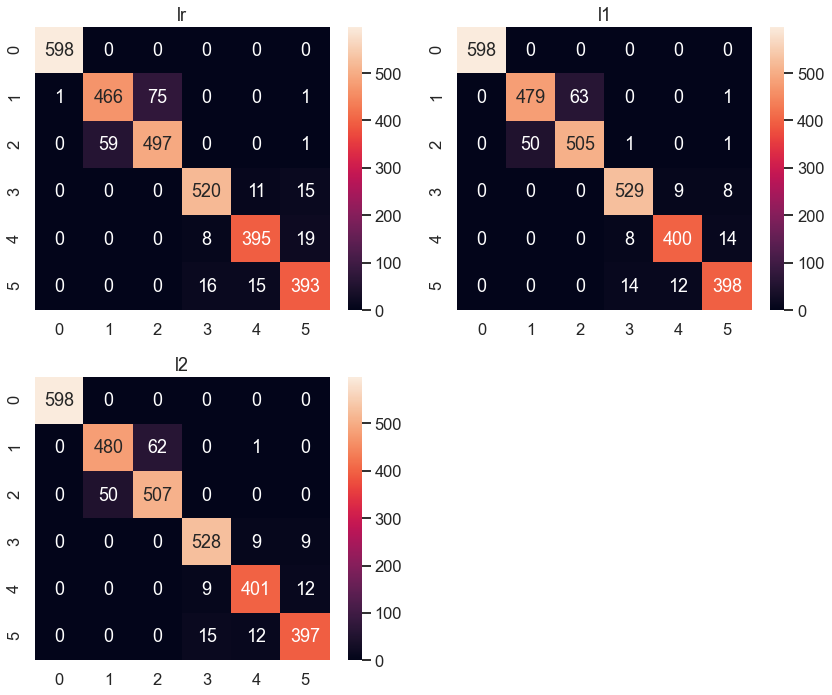

In [33]:
#Plot the confusion matrix
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis("off")

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm2[lab], ax=ax, annot=True, fmt="d")
    ax.set(title=lab);

plt.tight_layout()

In [ ]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation

In [ ]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation